In [1]:
import numpy as np
import matplotlib.pyplot as plt
from BuildGraph import EncodePriority
import os

In [3]:
sc = "Datasets/IDPCDU_Edges/set1/"
TaskNames = os.listdir(sc)
TaskNames

['idpc_10x10x1000.idpc',
 'idpc_10x20x2713.idpc',
 'idpc_10x5x425.idpc',
 'idpc_15x15x3375.idpc',
 'idpc_15x30x12111.idpc',
 'idpc_15x7x1504.idpc',
 'idpc_20x10x2492.idpc',
 'idpc_20x20x8000.idpc',
 'idpc_20x40x26104.idpc',
 'idpc_25x12x4817.idpc',
 'idpc_25x25x15625.idpc',
 'idpc_25x50x57147.idpc',
 'idpc_30x15x10025.idpc',
 'idpc_30x30x27000.idpc',
 'idpc_30x60x89772.idpc',
 'idpc_35x17x13934.idpc',
 'idpc_35x35x42875.idpc',
 'idpc_35x70x123585.idpc',
 'idpc_40x20x18485.idpc',
 'idpc_40x40x64000.idpc',
 'idpc_40x80x130681.idpc',
 'idpc_45x22x43769.idpc',
 'idpc_45x45x91125.idpc',
 'idpc_45x90x322081.idpc']

In [4]:
def Load(index):
    path = sc + TaskNames[index]
    name = TaskNames[index].split('.')[0]
    task = EncodePriority(path=path, name=name)
    return task

'idpc_10x5x425'

In [5]:
def GeneratorPopulaion(sizePop, task:EncodePriority):
    Populaion = []
    dims=task.NUM_DOMAIN
    for i in range(sizePop):
        pi = np.random.permutation(range(1, dims+1))
        f_pi = task.Cost(pi)
        Populaion.append((pi, f_pi))

    return Populaion

In [6]:
def chooseParents(pop):
    n = len(pop)
    index1 = np.random.randint(n)
    index2 = np.random.randint(n)
    while index1 == index2:
        index2 = np.random.randint(n)
    
    index3 = np.random.randint(n)
    index4 = np.random.randint(n)
    while index3 == index4:
        index4 = np.random.randint(n)
    
    if pop[index1][1] < pop[index2][1]:
        p1 = pop[index1][0]
    else:
        p1 = pop[index2][0]
    
    if pop[index3][1] < pop[index4][1]:
        p2 = pop[index3][0]
    else:
        p2 = pop[index4][0]
    
    return p1, p2

In [7]:
def cross_pmx(p1, p2):
    n = len(p1)
    
    index1 = np.random.randint(1, n-1)
    index2 = np.random.randint(1, n-1)
    while index1 == index2:
       index2 = np.random.randint(1, n-1)
   
    if index1 > index2:
        temp = index1
        index1 = index2
        index2 = temp

    #print(index1, index2)

    o1 = np.array(p2)
    o2 = np.array(p1)

    pos1 = np.full(n+1, -1, dtype=int)
    pos2 = np.full(n+1, -1, dtype=int)
    for i in range(index1, index2+1):
        pos1[o1[i]] = i
        pos2[o2[i]] = i
        
    for i in range(n):
        if index1 <= i and i <= index2: continue

        id1 = i
        while True:
            if pos1[p1[id1]] == -1:
                o1[i] = p1[id1]
                break
            id1 = pos1[p1[id1]]
        
        id2 = i
        while True:
            if pos2[p2[id2]] == -1:
                o2[i] = p2[id2]
                break
            id2 = pos2[p2[id2]]
    
    return o1, o2

In [8]:
def paradox_mutation(indiv):
    n = len(indiv)
    index1 = np.random.randint(1, n-1)
    index2 = np.random.randint(1, n-1)
    while index1 == index2:
       index2 = np.random.randint(1, n-1)
   
    if index1 > index2:
        temp = index1
        index1 = index2
        index2 = temp

    while index1 < index2:
        temp = indiv[index1]
        indiv[index1] = indiv[index2]
        indiv[index2] = temp
        index1 += 1
        index2 -= 1

    return indiv


In [9]:
def mutation_swap(individual):
    n = len(individual)
    res = np.array(individual)

    index1 = np.random.randint(n)
    index2 = np.random.randint(n)
    while index1 == index2:
        index2 = np.random.randint(n)

    temp = res[index1]
    res[index1] = res[index2]
    res[index2] = temp

    return res

In [10]:
def selection(pre_pop, offs_pop, rate_sel = 0.1):  
    n = len(pre_pop)
    n_p = int(n*rate_sel)
    n_o = int(n*(0.5 - rate_sel))
    pre_pop.sort(key=lambda tup: tup[1])
    offs_pop.sort(key=lambda tup: tup[1])
    pop = pre_pop[n_p:] + offs_pop[n_o:]
    pop.sort(key=lambda tup: tup[1])
    next_pop = pre_pop[0:n_p] + offs_pop[0:n_o] + pop[0:(n-n_p-n_o)]

    # pop = offs_pop + pre_pop
    # pop.sort(key=lambda tup: tup[1])
    # next_pop = pop[:n]

    return next_pop

In [11]:
from tqdm import tqdm

def GA(size_pop, num_gens, Pc, Pm, task:EncodePriority):
    population = GeneratorPopulaion(size_pop, task=task)
    logg = []

    for t in tqdm(range(num_gens)):
        offs_pop = []
        while len(offs_pop) < size_pop:
            p1, p2 = chooseParents(population)

            rand = np.random.random_sample()
            o1, o2 = [], []
            if rand <= Pc:
                o1, o2 = cross_pmx(p1, p2)
            else:
                o1 = paradox_mutation(p1)
                o2 = paradox_mutation(p2)
            if np.random.random_sample() < Pm:
                o1 = paradox_mutation(o1)
                o2 = paradox_mutation(o2)
            
            offs_pop.append((o1, task.Cost(o1)))
            offs_pop.append((o2, task.Cost(o2)))
        
        population = selection(population, offs_pop)
        logg.append([t, population[0]])
    
    return logg

In [12]:
def show(his):
    input = np.array(his, dtype=object)
    x = input[:, 0]
    y = np.array(input[:, 1])
    y = [i[1] for i in y]
    plt.plot(x, y)
    plt.title(Task.NAME + ": best = {}".format(his[-1][1][1]))
    plt.show()

In [13]:
np.random.seed(1)

100%|██████████| 1000/1000 [02:52<00:00,  5.79it/s]


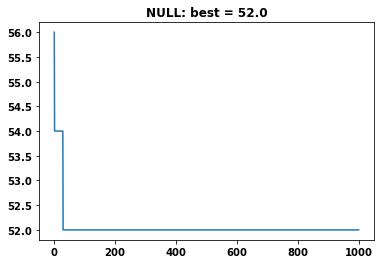

In [16]:
history = GA(50, 1000, 0.75, 0.1, task=Load(0))
show(history)